# Homework 1

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Part 2: Exercise 2 of Homework 1

In [15]:
def backtracking_line_search(x0, f, deltaX, df0, alpha=0.1, beta=0.7):
    """ 
    This function implements the backtracking line search method presented in the class
    
    Arguments:
    x0: the current guess (as a numpy array)
    f: the function to minimize (as a callable function), i.e. f(x0) should work
    deltaX: the descent direction (as a numpy vector)
    df0: the gradient of f at x0 (as a numpy vector)
    alpha: (optional argument) parameter for the linesearch as defined in class
    beta: (optional argument) parameter for the linesearch as defined in class
    
    Returns: a number between 0 and 1.
    """
    t = 1.
    f0 = f(x0)
    while(f(x0 + t * deltaX) > f0 + alpha * t * (df0.dot(deltaX))):
        t = t * beta
    return t
        

def gradient_descent(x0, f, df, max_n=1000, tol=10e-7):
    """
    This function implements gradient descent assuming that we have functional expressions
    for f and its gradient. It performs up to max_n iterations and stops when the new vector
    estimate is not improving any more (i.e. |x_old - x_new|<tol)
    
    Note: the stopping criteria is rather naive and could be smarter (cf. book of Boyd for 
    a better stopping criteria) - one should also check that the gradient is close to 0 - otherwise
    it might just mean that the  algorithm is stuck in a poorly conditioned part of the space
    
    Arguments:
    x0: an initial vector to start the minimization from
    f: the function to minimize (as a callable function), i.e. f(x0) should work
    df: the gradient of the function (as a callable function), i.e. df(x0) should work
    max_n: (optional argument) the maximum number of iterations
    tol: (optional argument) the stopping criteria, if |x_old - x_new|<tol then stop
    
    Returns: a numpy 2D array x_steps containing the successive iterations.
             x_steps[0,:] contains x0 and x_steps[-1,:] contains the last estimate of x
    """
    x_steps = np.empty([max_n+1, x0.size]) # allocate space for the sequence
    x_steps[0, :] = x0
    x_current = x0.copy()
    for i in range(max_n):
        df_current = df(x_current)
        deltaX = -df_current
        line_search = backtracking_line_search(x_current, f, deltaX, df_current)
        x_current += line_search * deltaX
        x_steps[i+1,:] = x_current

        if np.linalg.norm(x_steps[i,:] - x_current) < tol: #there was no improvement
            break
    if i==max_n-1:
        print("Reached the maximum number of iterations before convergence")
        
    return x_steps[:i+1,:]

def newton_method(x0, f, df, ddf, max_n=1000, tol=10e-7):
    """
    Arguments:
    df: a list of the second order gradient of the original function, i.e. df(x0) should work.
    """
    x_steps = np.empty([max_n+1, x0.size]) # allocate space for the sequence
    x_steps[0, :] = x0
    x_current = x0.copy()
    for i in range(max_n):
        # first order
        df_current = df(x_current)
        # second order
        H = ddf(x_current)
        if H.size == 1:
            H_inv = np.array([1. / H])
        else:
            H_inv = np.linalg.pinv(H)
        deltaXnt = -H_inv.dot(df_current)
        lambda_square = df_current.transpose().dot(H_inv).dot(df_current)
        if lambda_square <= tol:
            break
        # line search
        linesearch = backtracking_line_search(x0, f, deltaXnt, df_current)
        x_current = x_current + linesearch * deltaXnt
        x_steps[i+1,:] = x_current
    return x_steps[:i+1,:]

In [16]:
def plot_descent1D(x_steps, x, f):
    """
    plots the function f in the range x and displays the steps in x_steps
    Here we assume that the function has a 1D input
    
    Arguments:
    x_steps: the array containing iteration results for a descent algorithm
    x: the range of  values on which to evaluate f
    f: a callable function such that f(x) works
    """
    plt.figure()

    plt.plot(x, f(x), linewidth=2)

    for point in x_steps:
        plt.plot(point, f(point), 'x', markersize=10, markeredgewidth=4)
    plt.xlabel('x')
    plt.ylabel('f(x)')    
        
        
def plot_descent2D(x_steps, x_bounds, y_bounds, f, norm_scale=matplotlib.colors.Normalize()):
    """
    contour plot of the 2D function f in the interval x_bounds and y_bounds and display the steps in x_steps
    Here we assume that the function has a 2D input
    
    Arguments:
    x_steps: the array containing iteration results for a descent algorithm
    x_bounds: a numpy array or list with two elements, the smallest and largest values over which to evaluate x
    y_bounds: a numpy array or list with two elements, the smallest and largest values over which to evaluate y
    f: a callable function such that f(x) works where x is a 2D vector
    norm_scale: (optional argument) type of color scale to use for display
    """
    plt.figure()
    
    t1 = np.linspace(x_bounds[0], x_bounds[1], 100)
    t2 = np.linspace(y_bounds[0], y_bounds[1], 100)
    tX, tY = np.meshgrid(t1, t2)
    
    f_eval = np.empty_like(tX)
    
    it = np.nditer(tX, flags=['multi_index'])
    while not it.finished:
        f_eval[it.multi_index] = f(np.array([tX[it.multi_index], tY[it.multi_index]]))
        it.iternext()
    
    plt.contourf(tX, tY, f_eval, alpha=.75, cmap='jet', norm=norm_scale)

    plt.plot(x_steps[:,0], x_steps[:,1], '-kx', markersize=10, markeredgewidth=4, linewidth=4)


def compare_convergence(x_steps, p0, fig=None):
    """
    For each row of x_steps, plots its distance p0 (a numpy vector)
    It uses a logarithmic axis for y to show large changes of errors
    
    Arguments:
    x_steps: a 2D numpy array containing iterations of the optimizer
    p0: the optimal point to compare with
    fig: (optional) if given, the plot will be done using figure fig instead of creating a new figure 
        useful to overlay several iterations (e.g. to compare gradient descent and Newton's method)
    """
    
    if fig==None:
        fig = plt.figure()
    else:
        plt.figure(fig.number)
        
    rel_error = x_steps - p0
    plt.semilogy(range(len(x_steps[:,0])),np.linalg.norm(rel_error, axis=1))
    plt.xlabel('Number of iterations')
    plt.ylabel('Relative distance to p0')
    return fig

### 2.1 Minimize a 1D function using Newton Method

The function minimized here is 
$$f(x) = \mathrm{e}^{\frac{x^2}{100}}$$
Its first order gradient is
$$\frac{df}{dx} = \frac{x}{50}\mathrm{e}^{\frac{x^2}{100}}$$
Its second order gradient is
$$\frac{d^2f}{dx^2} = (\frac{1}{50} + \frac{x^2}{250})\mathrm{e}^{\frac{x^2}{100}}$$

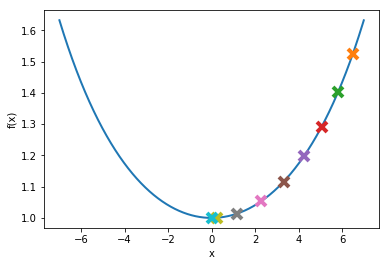

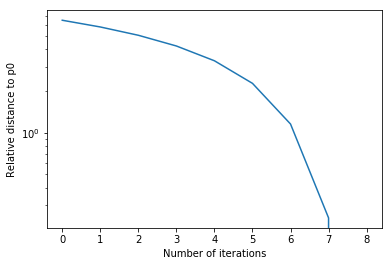

In [17]:
f = lambda x: np.exp(x**2 / 100.)  # lambda function defining f(x)
df = lambda x: (x/50.)*np.exp(x**2 / 100.) # lambda function defining df/dx
ddf = lambda x: (1/50. + x**2/250) * np.exp(x**2 / 100.) # lambda function defining d^2f/dx^2

# initial point from which we optimize
x0 = np.array([6.5])
x_steps = newton_method(x0, f, df, ddf)

# we  want to plot results from x=-10 to x=10
x = np.arange(-7.,7.,0.001)
# plot results
plot_descent1D(x_steps, x, f)
fig = compare_convergence(x_steps, x_steps[-1,:])

### Compare with Gradient Descent Algorithm

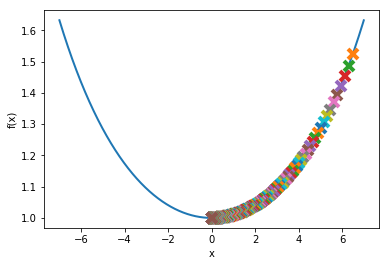

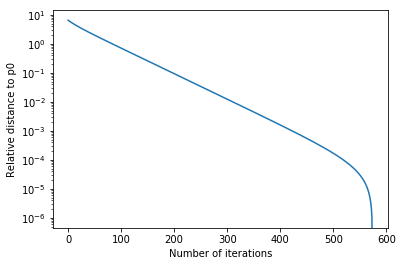

In [24]:
f = lambda x: np.exp(x**2 / 100.)  # lambda function defining f(x)
df = lambda x: (x/50.)*np.exp(x**2 / 100.) # lambda function defining df/dx

# initial point from which we optimize
x0 = np.array([6.5])
# gradient descent
x_steps = gradient_descent(x0, f, df)    

# we  want to plot results from x=-10 to x=10
x = np.arange(-7.,7.,0.001)
# plot results
plot_descent1D(x_steps, x, f)
fig = compare_convergence(x_steps, x_steps[-1,:])

### 2.2 Minimize a 2D function using Netwon Method

The function minimized here is:
$$f(x) = \frac{1}{2} x^T \begin{bmatrix}10&1\\1&2 \end{bmatrix}x$$ 
Its first order gradient is:
$$\frac{df}{dx} = \begin{bmatrix}10&1\\1&2 \end{bmatrix}x$$
Its first order gradient is:
$$\frac{d^2f}{dx^2} = \begin{bmatrix}10&1\\1&2 \end{bmatrix}$$

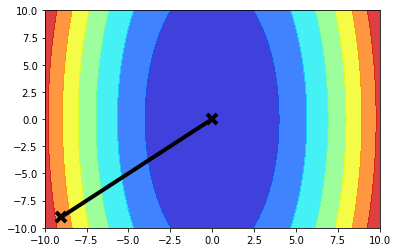

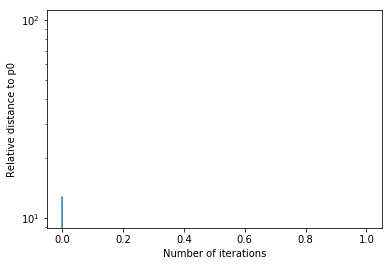

In [18]:
f = lambda x: 0.5*x.dot(np.array([[10,0],[0,1]])).dot(x) # lambda function defining f(x)
df = lambda x: np.array([[10,0],[0,1]]).dot(x) # lambda function defining df/dx
ddf = lambda x: np.array([[10,0],[0,1]])

# initial 2D point from which we optimize
x0 = np.array([-9., -9.])        
       
x_steps = newton_method(x0, f, df, ddf)

# we plot the results in a [-10,10]x[-10,10] box
plot_descent2D(x_steps, [-10., 10.], [-10., 10.], f)
fig = compare_convergence(x_steps, x_steps[-1,:])

### Compare with Gradient Descent

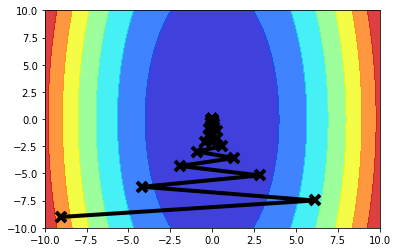

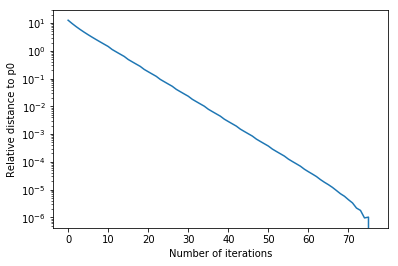

In [25]:
f = lambda x: 0.5*x.dot(np.array([[10,0],[0,1]])).dot(x) # lambda function defining f(x)
df = lambda x: np.array([[10,0],[0,1]]).dot(x) # lambda function defining df/dx

# initial 2D point from which we optimize
x0 = np.array([-9., -9.])        
       
# gradient descent    
x_steps = gradient_descent(x0, f, df) 
# we plot the results in a [-10,10]x[-10,10] box
plot_descent2D(x_steps, [-10., 10.], [-10., 10.], f)
fig = compare_convergence(x_steps, x_steps[-1,:])

## Exercise 3 of Homework 1
### Part 1

In [3]:
def do_regression(data_x, data_y, degree):
    """
    This function perform linear least squares to find a polynomial that fits the data
    
    Arguments:
    data_x: numpy array (1D) that contains the x data
    data_Y: numpy array (1D) that contains the y data
    degree: degree of  the polynomial to fit (1 is for a line)
    
    returns: an array of paramters for the fit
    """
    X = np.empty([len(data_x), degree+1])
    Y = np.empty([len(data_y)])
    # for each data point
    for i,x in enumerate(data_x):
        for j in range(degree+1):
            X[i,j] = x**j
        Y[i] = data_y[i]
    
    #construct X^T X
    XTX = X.transpose().dot(X)
    
    a = np.linalg.solve(XTX, X.transpose().dot(Y))
    
    fitting_error = (X.dot(a) - Y).dot(X.dot(a) - Y)
    
    return a, fitting_error

In [4]:
def polynomial_func(x, k):
    xx = np.array([x**i for i in range(k.size)])
    return xx.dot(k)

def do_test(test_x, test_y, degree, a):
    X = np.empty([len(test_x), degree+1])
    # for each data point
    for i,x in enumerate(test_x):
        for j in range(degree+1):
            X[i,j] = x**j
    fitting_error = (X.dot(a) - test_y).dot(X.dot(a) - test_y)
    return fitting_error

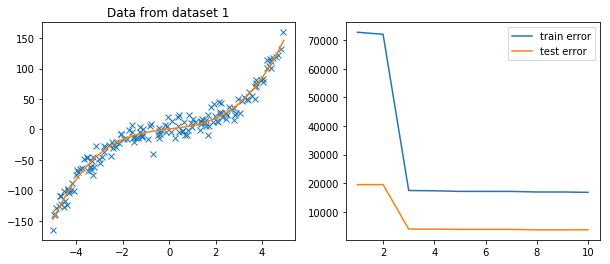

In [21]:
data1 = np.loadtxt('regression_dataset')

data_x = data1[:160,0]
data_y = data1[:160,1]

test_x = data1[160:,0]
test_y = data1[160:,1]
plot_x = np.sort(test_x)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(data_x, data_y, 'x')
plt.title('Data from dataset 1')

# plt.figure()
a, fitting_error = do_regression(data1[:,0], data1[:,1], 3)
plot_x_all = np.sort(data1[:,0])
plt.plot(plot_x_all, [polynomial_func(point, a) for point in plot_x_all])

plt.subplot(1, 2, 2)
num_tests = 10
train_error = np.zeros((num_tests, 1))
test_error = np.zeros((num_tests, 1))
for i in range(num_tests):
    a, fitting_error = do_regression(data_x, data_y, i+1)
    train_error[i] = fitting_error
    test_error[i] = do_test(test_x, test_y, i+1, a)

plt.plot(np.arange(num_tests) + 1, train_error, label='train error')
plt.plot(np.arange(num_tests) + 1, test_error, label='test error')
plt.legend()

### Part 2

In [13]:
def do_regression_periodic(data_x, data_y, t):
    s = data_x.shape
    if len(s) == 1:
        N, K = s[0], 1
        data_x = data_x.reshape((N, K))
    else:
        N, K = s
    W = np.zeros((N, 2 * K + 1))
    Y = np.zeros((N))
    # for each data point
    for i,x in enumerate(data_x):
        W[i][0] = 1.
        for k in range(K):
            tmp = (k+1) * t * 2 * np.pi * data_x[i][k]
            W[i][k+1] = np.cos(tmp)
            W[i][k+1+K] = np.sin(tmp)
        Y[i] = data_y[i]
    WTW = W.transpose().dot(W)
    a = np.linalg.solve(WTW, W.transpose().dot(Y))
    fitting_error = (W.dot(a) - Y).dot(W.dot(a) - Y)
    return a, fitting_error


def do_test_periodic(test_x, test_y, t, a):
    predicted = np.array([periodic_func(p, a, t) for p in test_x])
    return (predicted - test_y).dot(predicted - test_y)
    

def periodic_func(x, a, t):
    K = (len(a) - 1) // 2
    x = x.reshape((K, 1))
    a0 = a[0]
    a1 = a[1:K+1]
    b1 = a[K+1:2*K+1]
    w = np.zeros((2 * K + 1))
    w[0] = 1.
    for k in range(K):
        tmp = (k+1) * t * 2 * np.pi * x[k]
        w[k+1] = np.cos(tmp)
        w[k+1+K] = np.sin(tmp)
    return w.dot(a)

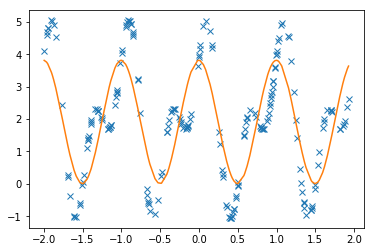

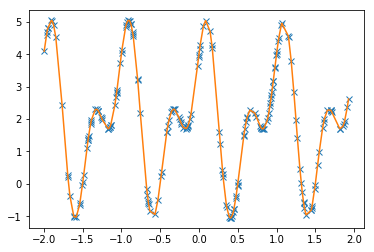

In [14]:
data2 = np.loadtxt('regression_dataset2')

data_x = data2[:,0]
data_y = data2[:,1]

plt.figure()
plt.plot(data_x, data_y, 'x')

a, fitting_error = do_regression_periodic(data_x, data_y, 1)
# a = np.array([1.91021086, 2.90038184, -0.03096971])
plot_x = np.sort(data_x)
plt.plot(plot_x, [periodic_func(p, a, 1) for p in plot_x])

plt.figure()
plt.plot(data_x, data_y, 'x')
m = len(data_x)
n = 2
X = np.zeros((m, n))
for i in range(m):
    X[i, :] = [data_x[i] for _ in range(n)]
plot_X = np.sort(X, axis=0)
a, fitting_error = do_regression_periodic(X, data_y, 1)
plt.plot(plot_x, [periodic_func(p, a, 1) for p in plot_X])